In [1]:
#Fix display to cover entire window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [700]:
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import os
import requests
import urllib3

from html.parser import HTMLParser

def torad(t) :
    return t*np.pi/180
def todeg(t):
    return t*180/np.pi 
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 16

from scipy.optimize import curve_fit
def line(x, m,b):
    return m*x+b


def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * 1/w).sum() / (1/w).sum()
    except ZeroDivisionError:
        return d.mean()

def get_xsi(x,qq):
    mm=0.93827
    xsi=2*x/(1+sqrt(1+4*mm**2*x**2/qq))
    return xsi
    

In [4]:
# create a password manager
password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()

# Add the username and password.
# If we knew the realm, we could use it instead of None.
top_level_url = "https://userweb.jlab.org/~gaskelld/XEMPT/results_may_2017/TABLES/40deg_au_newsys.dat"
username="xem"
password="xemrules!"
password_mgr.add_password(None, top_level_url, username, password)

handler = urllib.request.HTTPBasicAuthHandler(password_mgr)

# create "opener" (OpenerDirector instance)
opener = urllib.request.build_opener(handler)

# use the opener to fetch a URL
opener.open(top_level_url)

# Install the opener.
# Now all calls to urllib.request.urlopen use our opener.
tmp=urllib.request.install_opener(opener)


resp = requests.get(top_level_url)

In [5]:
# Open github API to test authentication 
from requests.auth import HTTPBasicAuth     
a=requests.get(top_level_url, auth=HTTPBasicAuth(username, password)) 
 
# or shortcut method 
#requests.get('https://api.github.com/user', auth=('user', 'pass'))  

In [204]:
'''This function pulls the tables from 
https://userweb.jlab.org/~gaskelld/XEMPT/results_may_2017/TABLES/
and converts them into Data frames. It will return a list/Dict of 
Dataframes. I will also attempt to provide nameinfo also.'''

from html.parser import HTMLParser

class Xem_table:
    
    def __init__(self, DF,name):
        self.DF=DF
        self.filename=name
    def add_spe(self,target,BeamE,angle,norm):
        self.Target=target
        self.angle=angle
        self.norm=norm
        self.BeamE=BeamE
        

#Top level into, list of tables and login info
top_url ='https://userweb.jlab.org/~gaskelld/XEMPT/results_may_2017/TABLES/'
username="xem"
password="xemrules!"    

# Grab the table list
from requests.auth import HTTPBasicAuth     
top_info=requests.get(top_url, auth=HTTPBasicAuth(username, password)) 

class MyHTMLParser(HTMLParser):
    #Initializing lists
    lsStartTags = list()
    lsEndTags = list()
    lsStartEndTags = list()
    lsComments = list()

    def handle_data(self, data):
        self.lsComments.append(data)
        

parser = MyHTMLParser()
parser.feed(top_info.text)
files=[]
for line in parser.lsComments:
    if ".dat" in line:
        files.append(line)
DFlist = []
Xem_tables=[]
for file in files:
    
    file_url = top_url+file
    
    
    from requests.auth import HTTPBasicAuth     
    a=requests.get(file_url, auth=HTTPBasicAuth(username, password)) 
    LinebyLine=a.text.split("\n")
    if "deg" in file:
        # Looking at diff kinematic files
        Notes = LinebyLine[:25]

        
        Headers=LinebyLine[25].split()
        if "**" in Headers:
            #pos=Headers.search("**")
            rm=Headers.index("**")
            Headers=Headers[rm+1:]
        if "corr" in Headers:
            Headers.remove("corr")
        if "corr." in Headers:
            Headers.remove("corr.")
        if "corr" in Headers:
            Headers.remove("corr")
        if "corr." in Headers:
            Headers.remove("corr.")       
            
        table_noheader=LinebyLine[26:]
        table= [Line.split() for Line in table_noheader ]

        DF=pd.DataFrame(table,columns=Headers)
        DF=DF.astype("double")
        DF=DF.dropna()
        
        Xem_t =Xem_table(DF,file)
        #Build up some file info: Target, angle,...
        end  =int(LinebyLine[0].find("-->"))
        begin=int(LinebyLine[0].find("**"))
        targets=LinebyLine[0][begin+3:end-1]
        #Xem_t.add_info("Target",targets)

        begin=int(LinebyLine[1].find("energy ="))
        end  =int(LinebyLine[1].find("GeV"))
        BeamE=LinebyLine[1][begin+8:end-1]
       
        begin=int(LinebyLine[1].find("angle="))
        end  =int(LinebyLine[1].find("deg"))
        angle=LinebyLine[1][begin+7:end-1]
        #Xem_t.add_info("Angle",angle)

        begin=int(LinebyLine[2].find("all"))
        end  =int(LinebyLine[2].find("fract"))
        norm =LinebyLine[2][begin+4:end-2]
        #Xem_t.add_info("Norm.",norm)
        #end of kineatic filesend
        Xem_t.add_spe(targets,BeamE,angle,norm)
    
    
    Xem_tables.append(Xem_t)
    DFlist.append(DF)
    
    
    
    
def GetDFXem(tgt="C/D", angle=40.0):
    global Xem_tables
    DF=  pd.DataFrame()

    for i in Xem_tables:
        if i.Target==tgt:
            if float(i.angle)==angle:
                DF=i.DF
    return DF
    

In [167]:
def TargetT(tgt):
    A=[]
    global Xem_tables
    for table in Xem_tables:
        if table.Target == tgt:
            A.append(table)
    return(A)
def angleT(angle):
    A=[]
    global Xem_tables
    for table in Xem_tables:
        if table.angle == angle:
            A.append(table)
    return(A)

In [8]:
CarbonT=TargetT("C/D")
deg40=angleT("40.0")

In [9]:
CarbonT[1].DF

,x,xi,Q2,W2,Ratio,Stat,Sys,Sys-xcorr,Iso.,Coul.
0,0.400,0.3780,2.2853,4.3083,0.9873,0.004512,0.01096,0.0,1.0,1.003
1,0.425,0.3997,2.3585,4.0713,0.9861,0.004585,0.01095,0.0,1.0,1.003
2,0.450,0.4211,2.4277,3.8475,0.9797,0.005632,0.01087,0.0,1.0,1.003
3,0.475,0.4422,2.4931,3.6359,0.9703,0.004619,0.01077,0.0,1.0,1.003
4,0.500,0.4631,2.5551,3.4354,0.9678,0.005748,0.01074,0.0,1.0,1.004
5,0.525,0.4836,2.6139,3.2453,0.9565,0.003908,0.01062,0.0,1.0,1.004
6,0.550,0.5039,2.6697,3.0647,0.9504,0.004513,0.01055,0.0,1.0,1.004
7,0.575,0.5240,2.7228,2.8929,0.9316,0.004802,0.01034,0.0,1.0,1.005
8,0.600,0.5437,2.7734,2.7293,0.9247,0.004851,0.01026,0.0,1.0,1.005
9,0.625,0.5632,2.8216,2.5733,0.9315,0.004985,0.01034,0.0,1.0,1.005


In [10]:
file_n = "/home/jbane/HallC/xem/EMC_data/xem_slopes_2017.dat"
file = open(file_n)
lines=file.readlines()
header=lines[4].split()
header.remove("*")
header.remove("unc.")
header.remove("unc.")
header.remove("unc.")

xem_EMCs = pd.read_table(file_n,
                        delim_whitespace=True,skiprows=5,header=None)
xem_EMCs.columns=header
xem_EMCs["A"]=xem_EMCs["A"].astype(int)

In [11]:
file_n = "/home/jbane/HallC/xem/EMC_data/e139_slopes.dat"
file = open(file_n)
lines=file.readlines()
header=lines[5].split()
header.remove("*")
header.remove("unc.")
header.remove("unc.")


E139_EMCs = pd.read_table(file_n,
                        delim_whitespace=True,skiprows=6,header=None)
E139_EMCs.columns=header


In [12]:
type(E139_EMCs["|dR/dx|"][1])

numpy.float64

In [13]:
class_slope = [0.340,0.347,0.472,0.539]
class_err   = [0.022,0.022,0.023,0.020]
class_A     = [12   ,27   ,56   ,208]

class_emc_dict = {}
class_emc_dict["A"]=class_A
class_emc_dict["|dR/dx|"]=class_slope
class_emc_dict["total"]=class_err
class_emc =pd.DataFrame.from_dict(class_emc_dict)

In [14]:
all_emc = pd.concat(
    [xem_EMCs[['A' ,"|dR/dx|","total"]],
     E139_EMCs[['A',"|dR/dx|","total"]],
     class_emc[['A',"|dR/dx|","total"]] ])
all_emc =all_emc.sort_values("A")

cname =all_emc.columns
numofc=len(cname)
ab={}

for i,col in enumerate(cname):
    ab[i]=all_emc.groupby("A").apply(wavg,col,"total" )

all_emc=pd.DataFrame.from_dict(ab)
all_emc.columns=cname


In [15]:
all_emc_nclass = pd.concat(
    [xem_EMCs[['A' ,"|dR/dx|","total"]],
     E139_EMCs[['A',"|dR/dx|","total"]],
     ])
all_emc_nclass =all_emc_nclass.sort_values("A")

ab={}
cname =all_emc.columns

for i,col in enumerate(cname):
    ab[i]=all_emc_nclass.groupby("A").apply(wavg,col,"total" )

all_emc_nclass=pd.DataFrame.from_dict(ab)
all_emc_nclass.columns=cname

In [16]:
A=[3,4,9,12,27,40,56,63,108,197,208]
nuc = ["$^{3}$He","$^4$He","$^9$Be","$^{12}$C","$^{27}$Al","$^{40}$Ca","$^{56}$Fe",
       "$^{63}$Cu","$^{107}$Ag","$^{197}$Au","$^{208}$Pb"]
Jlab= []
SLAC= []
CLAS= []
comb= []
for i,j in enumerate(A):
    if j in xem_EMCs["A"].values:
        kk=xem_EMCs["A"][xem_EMCs["A"]==j].index[0]
        Jlab.append("%.3f $\pm$ %.3f" %(xem_EMCs["|dR/dx|"][kk],
                                        xem_EMCs["total"][kk]))
       
    else :
        Jlab.append("-")
    
    if j in E139_EMCs["A"].values:
        kk=E139_EMCs["A"][E139_EMCs["A"]==j].index[0]
        SLAC.append("%.3f $\pm$ %.3f" %(E139_EMCs["|dR/dx|"][kk],
                                        E139_EMCs["total"][kk]))
       
    else :
        SLAC.append("-")
    
    if j in class_emc["A"].values:
        kk=class_emc["A"][class_emc["A"]==j].index[0]
        CLAS.append("%.3f $\pm$ %.3f" %(class_emc["|dR/dx|"][kk],
                                        class_emc["total"][kk]))
       
    else :
        CLAS.append("-")
 #   if j == 63:
 #       j=63.6
    comb.append("%.3f $\pm$ %.3f" %(all_emc["|dR/dx|"][j],
                                        all_emc["total"][j]))
        
    
    #print(A[i],"\t",Jlab[i],"\t",SLAC[i],"\t",CLAS[i])

emc_dict = {}
emc_dict["A"]=nuc
emc_dict["JLab E03-103"]=Jlab
emc_dict["SLAC E139"]=SLAC
emc_dict["CLAS"]=CLAS
emc_dict["Combined"] = comb
emc_table =pd.DataFrame.from_dict(emc_dict) 
emc_table.to_csv("/home/jbane/HallC/xem/emc_table_tex.csv",index=False)

In [400]:
DF_slac_c = pd.read_table("/home/jbane/HallC/xem/EMC_data/slac_e139_carbon.dat",delim_whitespace=True)
DF_slac_Au = pd.read_table("/home/jbane/HallC/xem/EMC_data/slac_e139_au.dat",delim_whitespace=True)
DF_slac_Fe = pd.read_table("/home/jbane/HallC/xem/EMC_data/slac_e139_fe.dat",delim_whitespace=True)


slac_data=pd.DataFrame
slac_data=DF_slac_c[['x','C/D','err']]
slac_data["Fe/D"]=DF_slac_Fe["Fe/D"]
slac_data["err.2"]=DF_slac_Fe["err"]
slac_data["Au/D"]=DF_slac_Au["Au/D"]
slac_data["err.3"]=DF_slac_Au["err"]

# Add isocor to slac DF
for col in slac_data.columns:
    if col=="Fe/D":
        a=56
        Z=26
    elif col=="Au/D":
        a=197
        Z=79
    elif col=="C/D":
        a=12
        Z=6  
    else:
        continue
    #calc isocor
    isocor_R =(1-0.8*slac_data["x"])        
    slac_data[col+"_isocor"] = 0.5*(1+isocor_R)  /((1/a)*(Z+(a-Z)*isocor_R) )

# Add in xi, using QQ = 5 Gev^2
slac_data["xi"]= get_xsi(slac_data["x"],5.0)

#reorder the cols
slac_data=slac_data[["x","xi","C/D","C/D_isocor","err","Fe/D","Fe/D_isocor","err.2","Au/D","Au/D_isocor","err.3"]]

In [20]:
emc_table

,A,JLab E03-103,SLAC E139,CLAS,Combined
0,$^{3}$He,0.085 $\pm$ 0.027,-,-,0.085 $\pm$ 0.027
1,$^4$He,0.186 $\pm$ 0.030,0.180 $\pm$ 0.060,-,0.184 $\pm$ 0.040
2,$^9$Be,0.250 $\pm$ 0.032,0.209 $\pm$ 0.037,-,0.231 $\pm$ 0.034
3,$^{12}$C,0.264 $\pm$ 0.033,0.300 $\pm$ 0.032,0.340 $\pm$ 0.022,0.307 $\pm$ 0.028
4,$^{27}$Al,-,0.295 $\pm$ 0.032,0.347 $\pm$ 0.022,0.326 $\pm$ 0.026
5,$^{40}$Ca,-,0.322 $\pm$ 0.037,-,0.322 $\pm$ 0.037
6,$^{56}$Fe,-,0.359 $\pm$ 0.039,0.472 $\pm$ 0.023,0.430 $\pm$ 0.029
7,$^{63}$Cu,0.376 $\pm$ 0.040,-,-,0.376 $\pm$ 0.040
8,$^{107}$Ag,-,0.420 $\pm$ 0.040,-,0.420 $\pm$ 0.040
9,$^{197}$Au,0.435 $\pm$ 0.059,0.394 $\pm$ 0.038,-,0.411 $\pm$ 0.046


In [21]:
all_emc_nclass.round(3)

,A,|dR/dx|,total
A,,,
3,3.0,0.085,0.027
4,4.0,0.184,0.040
9,9.0,0.231,0.034
12,12.0,0.282,0.032
27,27.0,0.295,0.032
40,40.0,0.322,0.037
56,56.0,0.359,0.039
63,63.0,0.376,0.040
108,108.0,0.420,0.040


/home/jbane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


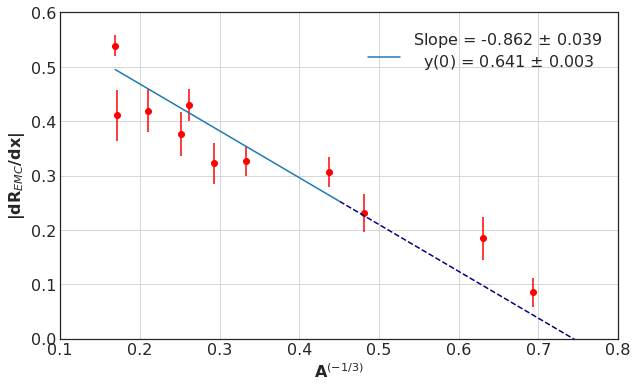

In [23]:
all_emcs = all_emc.query("A >= 12")


popt,pcov = curve_fit(line,all_emcs["A"]**(-1/3)
            ,all_emcs["|dR/dx|"],sigma=all_emcs["total"])




fit_x1=arange(11,208,1)**(-1/3)
fit_x2=arange(0,12,1)**(-1/3)
fit_y1 = line(fit_x1,popt[0],popt[1]) 
fit_y2 = line(fit_x2,popt[0],popt[1]) 



fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

A=[]

#ax.errorbar( x=xem_EMCs['A']**(-1/3), y=xem_EMCs["|dR/dx|"],fmt=" ",marker="o",
#            yerr=xem_EMCs["total"],label="Xem" ) 
#ax.errorbar( x=E139_EMCs['A']**(-1/3), y=E139_EMCs["|dR/dx|"],fmt=" ",marker="s",
#            yerr=E139_EMCs["total"],label="E139" ) 
#ax.errorbar( x=class_emc['A']**(-1/3), y=class_emc["|dR/dx|"],fmt=" ",marker="x",
#            yerr=class_emc["total"],label="CLAS" ) 
ax.errorbar( x=all_emc['A']**(-1/3), y=all_emc["|dR/dx|"],fmt=" ",marker="o",color="red",
            yerr=all_emc["total"]) #,label="combined" 
ax.errorbar(fit_x2,fit_y2,ls="--",color="navy")

A.append(ax.errorbar(fit_x1,fit_y1,
            label= "Slope = %.3f $\pm$ %.3f \n  y(0) = %.3f $\pm$ %.3f \n"
            %(popt[0],pcov[0][0],popt[1],pcov[1][1])))



ax.set_xlim(0.1,0.8)
ax.set_ylim(0.0,0.6)

ax.set_ylabel("|dR$_{EMC}$/dx|")
ax.set_xlabel("A$^{(-1/3)}$")
ax.grid(True)
ax.legend(handles=A)

fig.savefig("/home/jbane/HallC/xem/plots/py_plots/EMC_A-3rd.pdf",bbox_inches='tight')
fig.savefig("/home/jbane/HallC/xem/plots/py_plots/EMC_A-3rd.png",bbox_inches='tight')

/home/jbane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


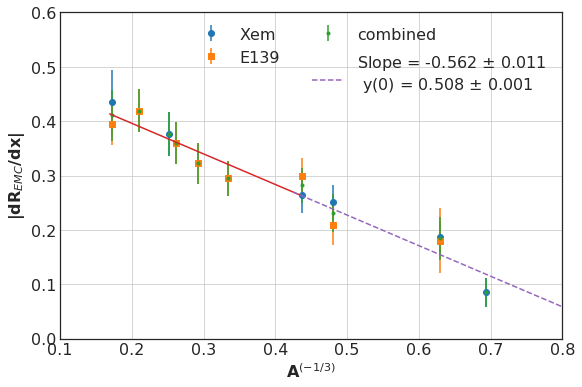

In [24]:
all_emcs_nc = all_emc_nclass.query("A >= 12")


popt,pcov = curve_fit(line,all_emcs_nc["A"]**(-1/3)
            ,all_emcs_nc["|dR/dx|"],sigma=all_emcs_nc["total"])




fit_x1=arange(12.2,208,1)**(-1/3)
fit_x2=arange(0,14,1)**(-1/3)
fit_y1 = line(fit_x1,popt[0],popt[1]) 
fit_y2 = line(fit_x2,popt[0],popt[1]) 



fig = plt.figure(figsize=((9,6)))
ax = fig.add_subplot(111)

ax.errorbar( x=xem_EMCs['A']**(-1/3), y=xem_EMCs["|dR/dx|"],fmt=" ",marker="o",
            yerr=xem_EMCs["total"],label="Xem" ) 
ax.errorbar( x=E139_EMCs['A']**(-1/3), y=E139_EMCs["|dR/dx|"],fmt=" ",marker="s",
            yerr=E139_EMCs["total"],label="E139" ) 

ax.errorbar( x=all_emc_nclass['A']**(-1/3), y=all_emc_nclass["|dR/dx|"],fmt=" ",marker=".",
            yerr=all_emc_nclass["total"],label="combined" ) 

ax.errorbar(fit_x1,fit_y1)
ax.errorbar(fit_x2,fit_y2,ls="--",
            label= "Slope = %.3f $\pm$ %.3f \n y(0) = %.3f $\pm$ %.3f \n"
            %(popt[0],pcov[0][0],popt[1],pcov[1][1]))



ax.set_xlim(0.1,0.8)
ax.set_ylim(0.0,0.6)

ax.set_ylabel("|dR$_{EMC}$/dx|")
ax.set_xlabel("A$^{(-1/3)}$")
ax.grid(True)
ax.legend(ncol=2)

fig.savefig("/home/jbane/HallC/xem/plots/py_plots/EMC_A-3rd_nclas.pdf",bbox_inches='tight')

/home/jbane/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


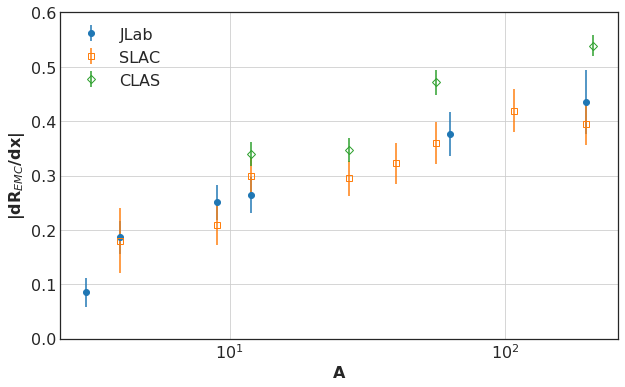

In [25]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.errorbar( x=xem_EMCs['A'], y=xem_EMCs["|dR/dx|"],fmt=" ",marker="o",
            yerr=xem_EMCs["total"],label="JLab" ) 
ax.errorbar( x=E139_EMCs['A'], y=E139_EMCs["|dR/dx|"],fmt=" ",marker="s",
            yerr=E139_EMCs["total"],fillstyle='none',label="SLAC" ) 
ax.errorbar( x=class_emc['A'], y=class_emc["|dR/dx|"],fmt=" ",marker="D",
            yerr=class_emc["total"],fillstyle='none',label="CLAS" ) 
#ax.errorbar( x=all_emc['A'], y=all_emc["|dR/dx|"],fmt=" ",marker=".",
#            yerr=all_emc["total"],label="combined" ) 


#ax.set_xlim(0.1,0.8)
ax.set_ylim(0.0,0.6)
ax.set_xscale("log")
ax.set_ylabel("|dR$_{EMC}$/dx|")
ax.set_xlabel("A")
ax.grid("True")
ax.legend()


fig.savefig("/home/jbane/HallC/xem/plots/py_plots/EMC_A-log.pdf",bbox_inches='tight')

In [26]:
clas_data= pd.read_table("/home/jbane/HallC/xem/EMC_data/emc_data_clas.dat",delim_whitespace=True)

(0.2, 0.8)

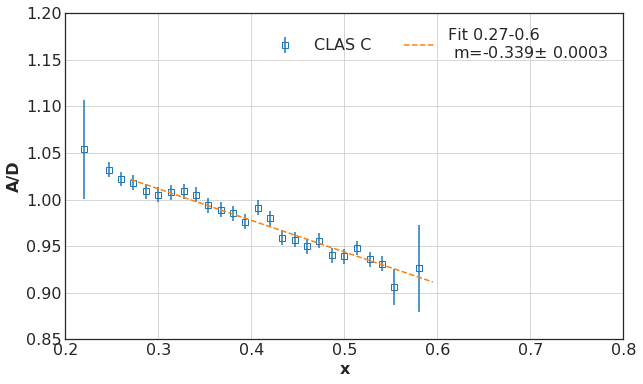

In [90]:
parms=[]
j=0
fit_x=[]
fit_y=[]

strts=[0.27]

for i in strts:
     
    parms.append( curve_fit(line,
                      clas_data.query("x>=%f"%i)["x"],
                      clas_data.query("x>=%f"%i)["C/D"],
                sigma=clas_data.query("x>=%f"%i)["err"]))
    
    fit_x.append(arange(i,0.6,0.025))
    fit_y.append( line(fit_x[j],parms[j][0][0],parms[j][0][1]) )
    j=j+1




C12xem=GetDFXem("C/D",40.0)
C12xem36=GetDFXem("C/D",36.0)


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

A=[]
A.append(ax.errorbar(x=clas_data["x"],y=clas_data["C/D"],
           yerr=clas_data["err"],fillstyle='none',fmt=' ',marker="s",label="CLAS C"))

for k,y in enumerate(fit_y):
       A.append(ax.errorbar(x=fit_x[k],y=y,fmt="--",
                    label="Fit %0.2f-0.6\n m=%.3f$\pm$ %.4f"%(i,parms[k][0][0],parms[k][1][0][0])
                   ))

        
        
tgt="C/D"        
Xemts=TargetT("tgt")        
Xemparms=[]
xem_x=[]
xem_y=[]
k=0

removeiso=1

for Xemt in XemTs:
    if Xemt.angle != '40.0':
        continue
    
    comberr = sqrt( (Xemt.DF["Stat"])**2+
               (Xemt.DF["Sys"])**2)
    Xemt.DF["Comb err"] =comberr
    #print( Carb.DF[["Comb err","Stat","Sys"]])
    
    if removeiso:
        isocorsh = Xemt.DF.query("x>=0.35 & x<=0.7")["Iso."]
        isocor = Xemt.DF["Iso."]
    else:
        isocorsh=1
        isocor=1
    
    Xemparms.append( curve_fit(line,
                      Xemt.DF.query("x>=0.35 & x<=0.7")["x"],
                      Xemt.DF.query("x>=0.35 & x<=0.7")["Ratio"]/isocorsh,
                ))
    
    xem_x.append(arange(0.35,0.7,0.025))
    xem_y.append( line(xem_x[k],Xemparms[k][0][0],Xemparms[k][0][1]) )
    
    

    A.append(ax.errorbar(x=Xemt.DF["x"],y=Xemt.DF["Ratio"]/isocor,
            yerr=comberr,fmt=' ',marker="s",label="XEM %s@%s$^{\circ}$"%(tgt[:-2],Xemt.angle)))
    A.append(ax.errorbar(x=xem_x[k],y=xem_y,fmt="-.",
                    label="Fit 0.35-0.7\n m=%.3f $\pm$ %.4f"%(Xemparms[k][0][0],Xemparms[k][1][0][0])
                   ))
    k=k+1
        

ax.legend(ncol=2,handles=A)#,loc='center left', bbox_to_anchor=(1, 0.5))


ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("A/D")
ax.set_ylim(0.85,1.2)
ax.set_xlim(0.2,0.8)

In [ ]:
emc_table

In [ ]:
parms=[]
j=0
fit_x=[]
fit_y=[]

strts=[0.2]

for i in strts:
     
    parms.append( curve_fit(line,
                      clas_data.query("x>=%f"%i)["x"],
                      clas_data.query("x>=%f"%i)["Fe/D"],
                sigma=clas_data.query("x>=%f"%i)["err.2"]))
    
    fit_x.append(arange(i,0.6,0.025))
    fit_y.append( line(fit_x[j],parms[j][0][0],parms[j][0][1]) )
    j=j+1



fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

A=[]
A.append(ax.errorbar(x=clas_data["x"],y=clas_data["Fe/D"],
           yerr=clas_data["err"],fillstyle='none',fmt=' ',marker="s",label="CLAS Fe"))

for k,y in enumerate(fit_y):
       A.append(ax.errorbar(x=fit_x[k],y=y,fmt="--",
                    label="Fit %0.2f-0.6\n m=%.3f$\pm$ %.4f"%(strts[k],parms[k][0][0],parms[k][1][0][0])
                   ))

tgt="Cu/D"       
XemTs=TargetT(tgt)        
Xemparms=[]
xem_x=[]
xem_y=[]
removeiso=1
k=0

removeiso=1

for Xemt in XemTs:
    if Xemt.angle != '40.0':
        continue
    
    comberr = sqrt( (Xemt.DF["Stat"])**2+
               (Xemt.DF["Sys"])**2)
    Xemt.DF["Comb err"] =comberr
    #print( Carb.DF[["Comb err","Stat","Sys"]])
    
    if removeiso:
        isocorsh = Xemt.DF.query("x>=0.35 & x<=0.7")["Iso."]
        isocor = Xemt.DF["Iso."]
    else:
        isocorsh=1
        isocor=1
    
    Xemparms.append( curve_fit(line,
                      Xemt.DF.query("x>=0.35 & x<=0.7")["x"],
                      Xemt.DF.query("x>=0.35 & x<=0.7")["Ratio"]/isocorsh,
                ))
    
    xem_x.append(arange(0.35,0.7,0.025))
    xem_y.append( line(xem_x[k],Xemparms[k][0][0],Xemparms[k][0][1]) )
    
    

    A.append(ax.errorbar(x=Xemt.DF["x"],y=Xemt.DF["Ratio"]/isocor,
            yerr=comberr,fmt=' ',marker="s",label="XEM %s@%s$^{\circ}$"%(tgt[:-2],Xemt.angle)))
    A.append(ax.errorbar(x=xem_x[k],y=xem_y,fmt="-.",
                    label="Fit 0.35-0.7\n m=%.3f $\pm$ %.4f"%(Xemparms[k][0][0],Xemparms[k][1][0][0])
                   ))
    k=k+1
        

ax.legend(ncol=2,handles=A)#,loc='center left', bbox_to_anchor=(1, 0.5))


ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("A/D")
ax.set_ylim(0.8,1.2)
ax.set_xlim(0.2,0.85)

In [ ]:
for Xemt in XemTs:
    print(Xemt.angle)

(0.2, 0.85)

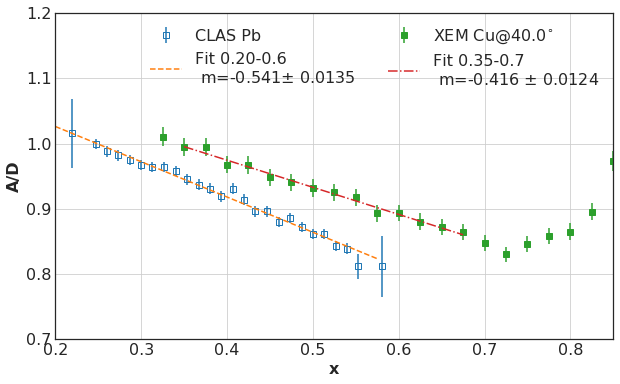

In [93]:
parms=[]
j=0
fit_x=[]
fit_y=[]

strts=[0.2]

for i in strts:
     
    parms.append( curve_fit(line,
                      clas_data.query("x>=%f"%i)["x"],
                      clas_data.query("x>=%f"%i)["Pb/D"],
                sigma=clas_data.query("x>=%f"%i)["err.2"]))
    
    fit_x.append(arange(i,0.6,0.025))
    fit_y.append( line(fit_x[j],parms[j][0][0],parms[j][0][1]) )
    j=j+1



fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

A=[]
A.append(ax.errorbar(x=clas_data["x"],y=clas_data["Pb/D"],
           yerr=clas_data["err"],fillstyle='none',fmt=' ',marker="s",label="CLAS Pb"))

for k,y in enumerate(fit_y):
       A.append(ax.errorbar(x=fit_x[k],y=y,fmt="--",
                    label="Fit %0.2f-0.6\n m=%.3f$\pm$ %.4f"%(strts[k],parms[k][0][0],sqrt(parms[k][1][0][0]))
                   ))

tgt="Cu/D"       
XemTs=TargetT(tgt)       
Xemparms=[]
xem_x=[]
xem_y=[]
k=0

removeiso=1

for Xemt in XemTs:
    if Xemt.angle != '40.0':
        continue
    
    comberr = sqrt( (Xemt.DF["Stat"])**2+
               (Xemt.DF["Sys"])**2)
    Xemt.DF["Comb err"] =comberr
    #print( Carb.DF[["Comb err","Stat","Sys"]])
    
    if removeiso:
        isocorsh = Xemt.DF.query("x>=0.35 & x<=0.7")["Iso."]
        isocor = Xemt.DF["Iso."]
    else:
        isocorsh=1
        isocor=1
    
    Xemparms.append( curve_fit(line,
                      Xemt.DF.query("x>=0.35 & x<=0.7")["x"],
                      Xemt.DF.query("x>=0.35 & x<=0.7")["Ratio"]/isocorsh,
                ))
    
    xem_x.append(arange(0.35,0.7,0.025))
    xem_y.append( line(xem_x[k],Xemparms[k][0][0],Xemparms[k][0][1]) )
    
    

    A.append(ax.errorbar(x=Xemt.DF["x"],y=Xemt.DF["Ratio"]/isocor,
            yerr=comberr,fmt=' ',marker="s",label="XEM %s@%s$^{\circ}$"%(tgt[:-2],Xemt.angle)))
    A.append(ax.errorbar(x=xem_x[k],y=xem_y,fmt="-.",
                    label="Fit 0.35-0.7\n m=%.3f $\pm$ %.4f"%(Xemparms[k][0][0],sqrt(Xemparms[k][1][0][0]))
                   ))
    k=k+1

#A.append(ax.errorbar(0, 0,fmt= '-', color='none', label=''))
#A.append(ax.errorbar(0, 0,fmt= '-', color='none', label=''))
    

ax.legend(ncol=2,handles=A)#,loc='center left', bbox_to_anchor=(1, 0.5))


ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("A/D")
ax.set_ylim(0.7,1.2)
ax.set_xlim(0.2,0.85)

In [94]:
Xemparms

[(array([-0.41582316,  1.14092055]), array([[ 1.52679858e-04, -8.01569245e-05],
         [-8.01569245e-05,  4.38636499e-05]]))]

In [735]:
def chisq(exp,obs,err):
    return sum((exp-obs)**2/err**2)

def emcplots():

    for l,t in enumerate(targets_xem):
        tgt_xem   = targets_xem[l]
        tgt_clas  = targets_clas[l]
        tgt_slac  = targets_slac[l]
        
        
        
        
        A=[]       
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)
        
        #################################################################################################################################
        if "CLAS" in which_plots:
            # clas info
            if tgt_slac =="":
                abc="abc"
            else:
            
                parms=[]
                j=0
                fit_x=[]
                fit_y=[]


                
                
                strts=[0.3]

                for i in strts:

                    # determine which error needs to be used
                    errmod=''
                    if tgt_clas=="Cu/D":
                        errmod='.2'
                    elif tgt_clas=="Au/D":
                        errmod='.3'


                        axis="x"
                

                        
                        
                    parms.append( curve_fit(line,
                                      clas_data.query("x>=%f"%i)["x"],
                                      clas_data.query("x>=%f"%i)[tgt_clas],
                                sigma=clas_data.query("x>=%f"%i)["err%s"%(errmod)]))
                    fit_x.append(arange(i,0.6,0.025))
                    fit_y.append( line(fit_x[j],parms[j][0][0],parms[j][0][1]) )
                    j=j+1
                #
                x=clas_data["x"]
                y=clas_data[tgt_clas]
                yerr=clas_data["err%s"%(errmod)]


                A.append(ax.errorbar(x=x,y=y,yerr=yerr,fillstyle='none',fmt=' ',marker="s",label="CLAS %s"%(tgt_clas[:-2])))

                for k,y in enumerate(fit_y):
                    
                    chisqu= chisquare(clas_data.query("x>=%f"%strts[k])[tgt_clas] , 
                                      line (clas_data.query("x>=%f"%strts[k])["x"],parms[k][0][0],parms[k][0][1]) ) 
                    
                    
                    
                    A.append(ax.errorbar(x=fit_x[k],y=y,fmt="--",
                                    label="Fit %0.2f-0.6\nm=%.3f$\pm$\n%.4f\n$\\tilde{\chi}^2$ = %.2e"%(strts[k],
                                            parms[k][0][0],sqrt(parms[k][1][0][0]),chisqu.statistic)
                                   ))

                #A.append(ax.errorbar(0, 0,fmt= '-', color='none', label=''))
                #A.append(ax.errorbar(0, 0,fmt= '-', color='none', label=''))
            ###################################################################################################
        if "SLAC" in which_plots:
        
            if tgt_slac =="":
                abc="abc"
            else:
            
                # determine which error needs to be used
                errmod=''
                if tgt_slac=="Fe/D":

                    errmod='.2'
                    a=56
                    Z=26
                elif tgt_slac=="Au/D":

                    errmod='.3'
                    a=197
                    Z=79
                elif tgt_slac=="C/D":

                    a=12
                    Z=6  
                else:
                    print( "cant find A/D name , or A and Z")
                    break


                # slac info
                parms=[]

                j=0
                fit_x=[]
                fit_y=[]
                strts=[0.3]

                for i in strts:


                    if removeiso_slac:

                        isocorsh_R = (1-0.8*slac_data.query("x>=%.2f & x<=0.7"%i)["x"])
                        isocor_R =(1-0.8*slac_data["x"])        
                        isocorsh = 0.5*(1+isocorsh_R)/((1/a)*(Z+(a-Z)*isocorsh_R) )
                        isocor   = 0.5*(1+isocor_R)  /((1/a)*(Z+(a-Z)*isocor_R)   )
                        yopt="uniso"                   
                    else:

                        yopt=tgt_slac
                        isocorsh=1
                        isocor=1

                    slac_data['isocor']=isocor



                    slac_data['uniso']=slac_data[tgt_slac]/slac_data['isocor']

                    #df = slac_data[slac_data[tgt_slac] > 0.0]
                    #df['isocor'] = isocor
                    #df=df.dropna()
                    #x =df["x"]

                    #if removeiso_slac:
                    #    y =df[tgt_slac]/df['isocor']
                    #else:
                    #    y = df[tgt_slac]


                   # print(slac_data.query("x>=%f & x<0.71"%i )["err%s"%(errmod)])


                    #print(yopt)
                    parms.append( curve_fit(line,
                                      slac_data.query("x>=%f & x<0.71"%i )["x"],
                                      slac_data.query("x>=%f & x<0.71"%i )['uniso'],
                                sigma=slac_data.query("x>=%f & x<0.71"%i )["err%s"%(errmod)]))


                    fit_x.append(arange(i,0.7,0.025))
                    fit_y.append( line(fit_x[j],parms[j][0][0],parms[j][0][1]) )
                    #print(parms[j])
                    j=j+1

                #



                #err=df["err%s"%(errmod)]


                A.append(ax.errorbar(x=slac_data['x'],y=slac_data['uniso'],yerr=slac_data["err%s"%(errmod)]
                                     ,fillstyle='none',fmt=' ',marker="s",label="SLAC %s"%(tgt_slac[:-2])))

                for k,y in enumerate(fit_y):
                    chisqu= chisquare(slac_data.query("x>=%f & x<0.71"%strts[k] )[tgt_slac] ,
                                      line (slac_data.query("x>=%f & x<0.71"%strts[k])["x"] ,parms[k][0][0],parms[k][0][1]) ) 
                    A.append(ax.errorbar(x=fit_x[k],y=y,fmt="-.",
                                    label="Fit %0.2f-0.7\nm=%.3f$\pm$\n%.4f\n$\\tilde{\chi}^2$ = %.2e"%(strts[k],parms[k][0][0]
                                                                                                        ,sqrt(parms[k][1][0][0]),chisqu.statistic)
                                   ))
                #A.append(ax.errorbar(0, 0,fmt= '-', color='none', label=''))
        ###################################################################################################
        
        if "XEM" in which_plots:
            tgt=tgt_xem
            
            if tgt =="":
                abc="abc"
            else:
                XemTs=TargetT(tgt)       
                Xemparms=[]
                xem_x=[]
                xem_y=[]


                k=0

                for Xemt in XemTs:
                    if Xemt.angle != '40.0':
                        continue

                    comberr = sqrt( (Xemt.DF["Stat"])**2+
                               (Xemt.DF["Sys"])**2)
                    Xemt.DF["Comb err"] =comberr
                    #print( Xemt.DF[["Comb err","Stat","Sys"]])



                    strts=[0.3]

                    for k,i in enumerate(strts):


                        if removeiso_xem:
                            isocorsh = Xemt.DF.query("x>=%f & x<=0.7"%i)["Iso."]
                            isocor = Xemt.DF["Iso."]
                        else:
                            isocorsh=[1]*len(Xemt.DF.query("x>=%f & x<=0.7"%i)['x'])
                            isocor=[1]*len(Xemt.DF['x'])

                            
                        print(type(Xemt.DF))

                        Xemparms.append( 
                            curve_fit(f=line,xdata=Xemt.DF.query("x>=%f & x<0.71"%i )["x"],
                                    ydata=Xemt.DF.query("x>=%f & x<0.71"%i )["Ratio"]/isocorsh,
                                    sigma=Xemt.DF.query("x>=%f & x<0.71"%i )["Comb err"]
                                     )
                        )




                        xem_x.append(arange(i,0.7,0.025))           
                        xem_y.append( line(xem_x[k],Xemparms[k][0][0],Xemparms[k][0][1]) )




                    A.append(ax.errorbar(x=Xemt.DF["x"],y=Xemt.DF["Ratio"]/isocor,
                                yerr=Xemt.DF["Comb err"],fmt=' ',marker="s",label="XEM %s@%s$^{\circ}$"%(tgt[:-2],Xemt.angle)))

                    for k,y in enumerate(xem_y):
                        chisqu= chisquare(Xemt.DF["Ratio"]/isocor , line (Xemt.DF["x"],Xemparms[k][0][0],Xemparms[k][0][1]) ) 
                        A.append(ax.errorbar(x=xem_x[k],y=xem_y[k],fmt="",
                                        label="Fit %.2f-0.7\nm=%.3f $\pm$\n%.4f\n$\\tilde{\chi}^2$ = %.2e"%(
                                            strts[k],Xemparms[k][0][0],sqrt(Xemparms[k][1][0][0]),chisqu.statistic)
                                       ))

                    k=k+1

                #
        #which plots   
        ncols = len(which_plots)

        leg_opt='upper right'
        if ncols>2:
            leg_opt ='upper left'
        ax.legend(ncol=ncols,handles=A,loc=leg_opt)#, bbox_to_anchor=(1, 0.5))
        
        #maxy = max([max(Xemt.DF["Ratio"]),max(slac_data['uniso']),max(clas_data[tgt_clas])])
            
            
        ax.grid(True)
        ax.set_xlabel("x")
        ax.set_ylabel("A/D")
        ax.set_ylim(0.72,1.35)
        ax.set_xlim(0.2,0.85)
        axs.append(ax)
        figs.append(fig)

    return figs,axs


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


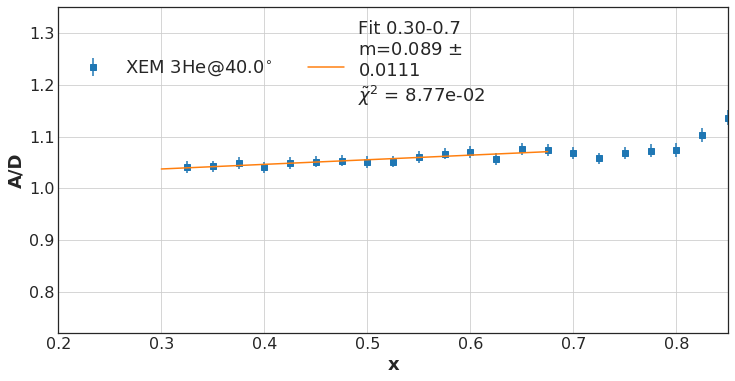

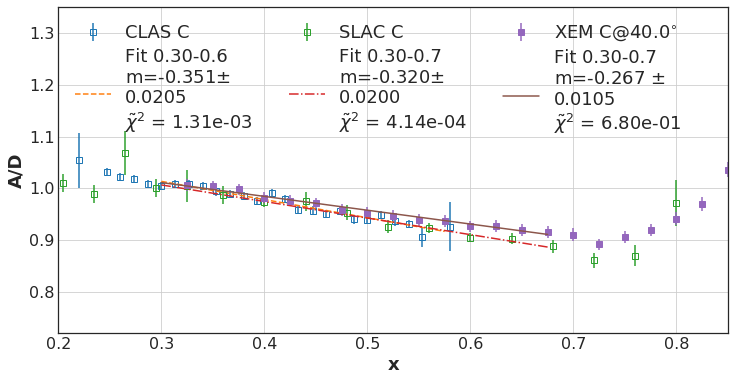

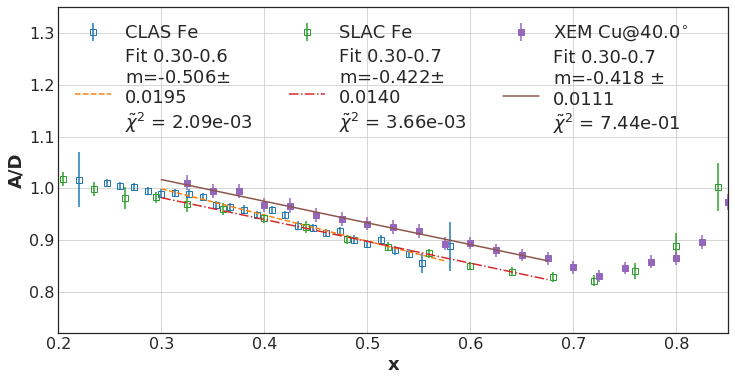

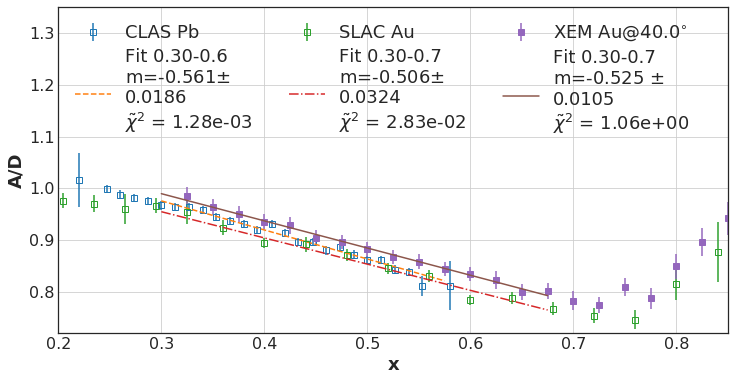

In [705]:
from scipy.stats import chisquare


figs=[]
axs=[]
removeiso_xem=1
removeiso_slac=1
which_plots = ["CLAS","SLAC","XEM"]
targets_xem =["3He/D","C/D","Cu/D","Au/D"]  
targets_clas=["","C/D","Fe/D","Pb/D"]
targets_slac=["","C/D","Fe/D","Au/D"]

figs, axes =emcplots()

In [162]:
figs[0].savefig("/home/jbane/HallC/xem/EMC_3exps_noiso_%s.png"%targets_xem[0][:1],bbox_inches='tight')
figs[1].savefig("/home/jbane/HallC/xem/EMC_3exps_noiso_%s.png"%targets_xem[1][:2],bbox_inches='tight')
figs[2].savefig("/home/jbane/HallC/xem/EMC_3exps_noiso_%s.png"%targets_xem[2][:2],bbox_inches='tight')

-0.41582315782503104

In [ ]:
chisqu()

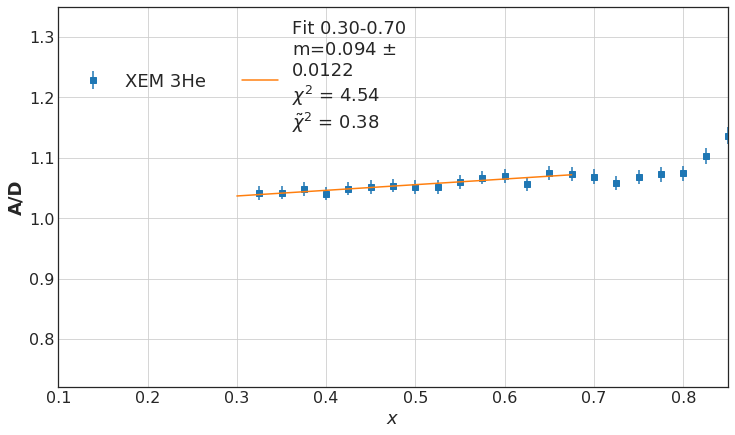

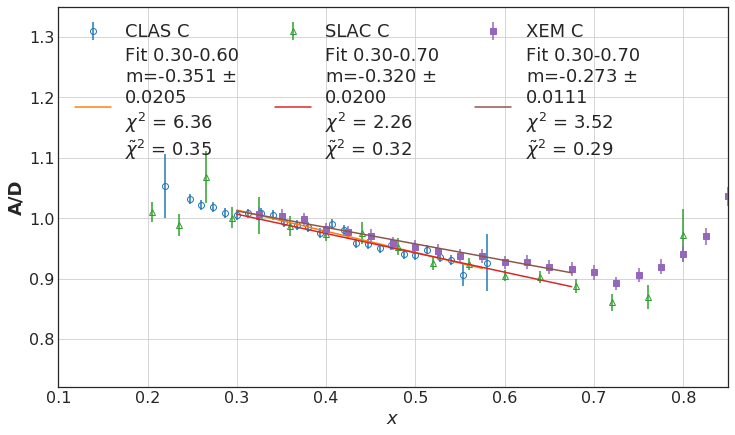

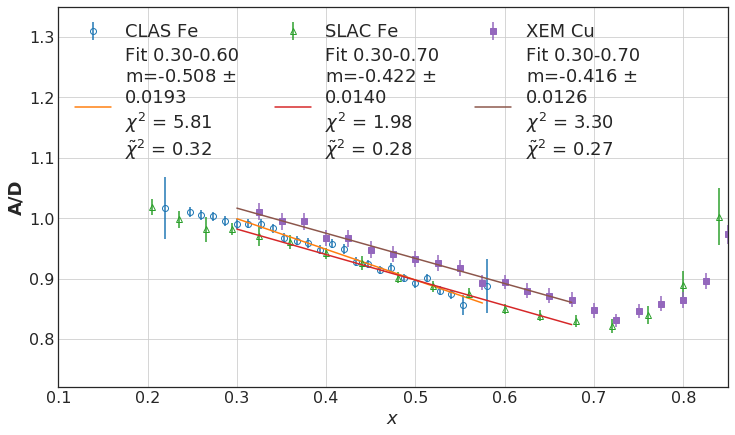

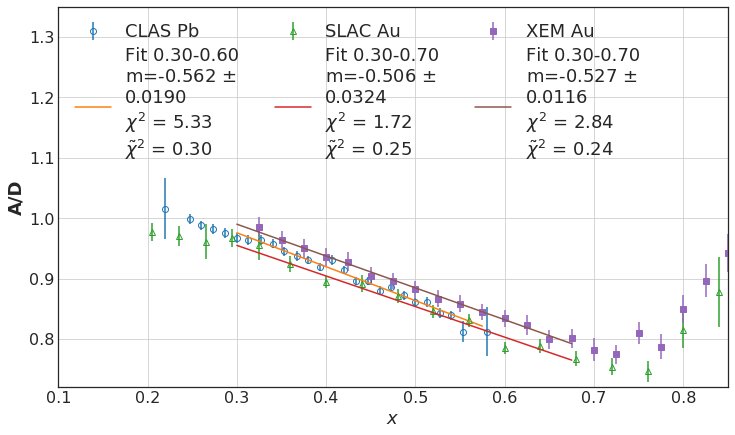

In [770]:
figs=[]
axs=[]
removeiso=1
removeiso_xem=1
removeiso_slac=1
which_plots = ["CLAS","SLAC","XEM"]
targets_xem =["3He/D","C/D","Cu/D","Au/D"]  
targets_clas=["","C/D","Fe/D","Pb/D"]
targets_slac=["","C/D","Fe/D","Au/D"]

xaxis="x"
fits=1
strts=[[0.3],[0.3],[0.3]]
ends =[0.7,0.6,0.7]



for l,t in enumerate(targets_xem):
    #target for each exp.
    tgt_xem   = targets_xem[l]
    tgt_clas  = targets_clas[l]
    tgt_slac  = targets_slac[l]
    
    A=[]       
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(111)
    errmod=''

    
    
    for exp in which_plots:
        x_fit=[]
        y_fit=[]
        parms=[] 
        #select the correct dataframe and target, exp_num for fitting
        if exp == "CLAS":
            DF=clas_data.copy()
            tgt=tgt_clas
            exp_num=1
        elif exp == "SLAC":
            tgt=tgt_slac
            DF=slac_data.copy()
            exp_num=2
        elif exp == "XEM":
            tgt=tgt_xem
            DF = GetDFXem(tgt_xem,40.0).copy()
            exp_num=0
        if tgt=="":
            #Make sure there is a tgt
            continue
        #determine which error to use
        if tgt == "Fe/D":
            errmod=".2"
        elif tgt == "Pb/D" or tgt == "Au/D":
            errmod=".3"
        #select the correct axis names
        if exp =="XEM":
            yaxis="Ratio"
        else:
            yaxis=tgt
        #isoscalar corrections:
        if removeiso:
            if exp == "SLAC":            
                DF["y"]=DF[yaxis]/DF[tgt+"_isocor"]
            if exp =="XEM":
                DF["y"]=DF[yaxis]/DF["Iso."]
            if exp =="CLAS":
                DF["y"]=DF[yaxis]
        else:
            DF["y"]=DF[yaxis]
            
        if exp == "SLAC" or  exp == "CLAS":
            yerr="err%s"%errmod
        else: 
            comberr = sqrt( (DF["Stat"])**2+(DF["Sys"])**2)
            yerr="comberr"
            DF[yerr]=comberr      
        #Plot marker, fmt, and yerr
        if exp =="XEM":
            fstyle="full"
            fmt=" "
            marker="s"
            
        if exp =="CLAS":
            fstyle="none"
            fmt=" "
            marker="o"
        if exp =="SLAC":
            fstyle="none"
            fmt=" "
            marker="^"
        #maybe ksi
        if xaxis == "xi":
            if exp =="SLAC":
                qq=5.0
                x=DF["x"]
            elif exp =="CLAS":
                qq=arange(0.8,2,(2-0.8)/len(DF["x"]))
                x=DF["x"]
            elif exp =="XEM":
                qq=DF["Q2"]
                x=DF["x"]
            DF["xi"]=get_xsi(x,qq)
            
        A.append(ax.errorbar(x=DF[xaxis],y=DF["y"],yerr=DF[yerr],fillstyle=fstyle,fmt=fmt,marker=marker,label="%s %s"%(exp,tgt[:-2]))) 
        
        if fits:
            for i,strt in enumerate(strts[exp_num]):
                
                parms.append(
                    curve_fit(f=line,
                          xdata=DF.query("x>=%f & x<%f"%(strt,ends[exp_num]))[xaxis],
                          ydata=DF.query("x>=%f & x<%f"%(strt,ends[exp_num]))["y"],
                          sigma=DF.query("x>=%f & x<%f"%(strt,ends[exp_num]))[yerr]
                             )
                )
                x_fit.append(arange(strt,ends[exp_num],0.025))           
                y_fit.append( line(x_fit[i],parms[i][0][0],parms[i][0][1]) )
                
                
                chisqu= chisquare(DF.query("x>=%f & x<%f"%(strt,ends[exp_num]))[xaxis] ,
                                  line (DF.query("x>=%f & x<%f"%(strt,ends[exp_num]))[xaxis],parms[i][0][0],parms[i][0][1]) ) 
                
                A.append(
                    ax.errorbar(
                        x=x_fit[i],
                        y=y_fit[i],
                        fmt="",
                        label="Fit %.2f-%.2f\nm=%.3f $\pm$\n%.4f\n$\chi^2$ = %.2f\n$\\tilde{\chi}^2$ = %.2f"%
                            (strt, ends[exp_num], parms[i][0][0], sqrt(parms[i][1][0][0]), 
                                            chisqu.statistic,
                                            chisqu.statistic/(len(DF.query("x>=%f & x<%f"%(strt,ends[exp_num]))[xaxis]))
                            )
                    )
                )
                
            
    #which plots   
    ncols = len(which_plots)

    leg_opt='upper right'
    if ncols>2:
        leg_opt ='upper left'
    ax.legend(ncol=ncols,handles=A,loc=leg_opt)#, bbox_to_anchor=(1, 0.5))

    #maxy = max([max(Xemt.DF["Ratio"]),max(slac_data['uniso']),max(clas_data[tgt_clas])])

    if xaxis =="x":
        xlabel="$x$"
    elif xaxis =="xi":
        xlabel="$\\xi$"
        
    ax.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("A/D")
    ax.set_ylim(0.72,1.35)
    ax.set_xlim(0.1,0.85)
    figs.append(fig)
    axs.append(ax)


In [755]:
parms[i]

(array([0.10459625, 1.00592959]), array([[ 1.88022854e-04, -8.88083865e-05],
        [-8.88083865e-05,  4.36706973e-05]]))

Text(0.25,0.73,'No ccor.')

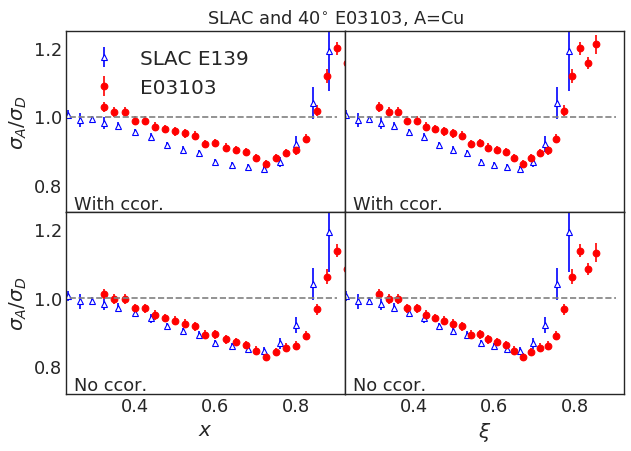

In [415]:
#figure 19 2 2*2 Cu / Au 

# left bin by x : right bin by xi
# top with ccor, botton no ccor


figt = plt.figure(figsize=(9,6),dpi=80)
ax_tl = figt.add_subplot(2,2,1)
ax_tl.axes.get_xaxis().set_visible(False)
ax_tr = figt.add_subplot(222,sharey=ax_tl)
ax_tr.axes.get_xaxis().set_visible(False)
ax_tr.axes.get_yaxis().set_visible(False)
ax_bl = figt.add_subplot(223,sharex=ax_tl)
ax_br = figt.add_subplot(224,sharey=ax_bl,sharex=ax_tr)
ax_br.axes.get_yaxis().set_visible(False)
figt.subplots_adjust(wspace=0, hspace=0)

DF = GetDFXem("Cu/D",40.0)


###top right
ax_tl.errorbar(x=slac_data["x"],y=slac_data["Fe/D"],yerr=slac_data["err.2"]
            ,fmt=" ", color="blue",markerfacecolor="white",marker='^'
            ,label="SLAC E139")
ax_tl.errorbar(x=DF["x"],y=DF["Ratio"],yerr=DF["Comb err"]
            ,fmt=" ", color="red",marker='o'
            ,label="E03103")
ax_tl.errorbar(x=arange(0,1,0.1),y=1.0,fmt="--",color="grey")


###Bottom left
ax_bl.errorbar(x=slac_data["x"],y=slac_data["Fe/D"],yerr=slac_data["err.2"]
            ,fmt=" ", color="blue",markerfacecolor="white",marker='^'
            )
ax_bl.errorbar(x=DF["x"],y=DF["Ratio"]/DF["Coul."],yerr=DF["Comb err"]
            ,fmt=" ", color="red",marker='o'
            )
ax_bl.errorbar(x=arange(0,1,0.1),y=1.0,fmt="--",color="grey")


###top right
ax_tr.errorbar(x=slac_data["xi"],y=slac_data["Fe/D"],yerr=slac_data["err.2"]
            ,fmt=" ", color="blue",markerfacecolor="white",marker='^'
            )
ax_tr.errorbar(x=DF["xi"],y=DF["Ratio"],yerr=DF["Comb err"]
            ,fmt=" ", color="red",marker='o'
            )
ax_tr.errorbar(x=arange(0,1,0.1),y=1.0,fmt="--",color="grey")

##Bottom right
ax_br.errorbar(x=slac_data["xi"],y=slac_data["Fe/D"],yerr=slac_data["err.2"]
            ,fmt=" ", color="blue",markerfacecolor="white",marker='^'
            )
ax_br.errorbar(x=DF["xi"],y=DF["Ratio"]/DF["Coul."],yerr=DF["Comb err"]
            ,fmt=" ", color="red",marker='o'
            )
ax_br.errorbar(x=arange(0,1,0.1),y=1.0,fmt="--",color="grey")


ax_tl.legend(loc="upper left")
ax_tl.set_ylabel("$ \sigma_A/\sigma_D $")
ax_bl.set_ylabel("$ \sigma_A/\sigma_D $")
ax_bl.set_xlabel("$x$")
ax_br.set_xlabel("$\\xi$")
ax_tl.set_ylim(0.72,1.25)
ax_bl.set_ylim(0.72,1.25)
ax_bl.set_xlim(0.23,0.92)
ax_br.set_xlim(0.23,0.92)
figt.suptitle("SLAC and 40$^{\circ}$ E03103, A=Cu",y=0.93)

ax_tl.text(0.25, 0.73, 'With ccor.')
ax_bl.text(0.25, 0.73, 'No ccor.')
ax_tr.text(0.25, 0.73, 'With ccor.')
ax_br.text(0.25, 0.73, 'No ccor.')

Text(0.25,0.73,'No ccor.')

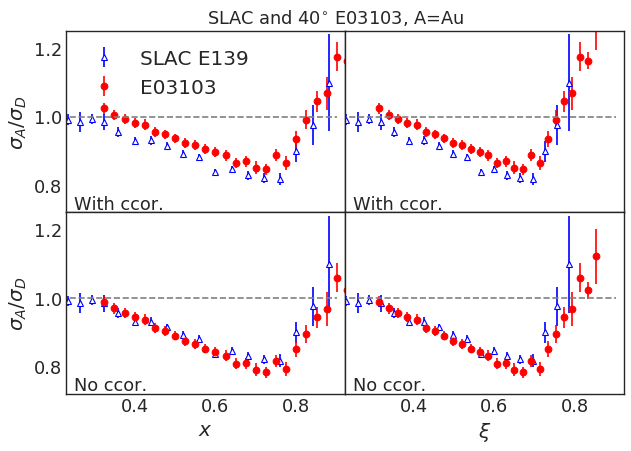

In [413]:
#figure 19 2 2*2 Cu / Au 

# left bin by x : right bin by xi
# top with ccor, botton no ccor


figb = plt.figure(figsize=(9,6),dpi=80)
ax_tl = figb.add_subplot(2,2,1)
ax_tl.axes.get_xaxis().set_visible(False)
ax_tr = figb.add_subplot(222,sharey=ax_tl)
ax_tr.axes.get_xaxis().set_visible(False)
ax_tr.axes.get_yaxis().set_visible(False)
ax_bl = figb.add_subplot(223,sharex=ax_tl)
ax_br = figb.add_subplot(224,sharey=ax_bl,sharex=ax_tr)
ax_br.axes.get_yaxis().set_visible(False)
figb.subplots_adjust(wspace=0, hspace=0)

DF = GetDFXem("Au/D",40.0)


###top right
ax_tl.errorbar(x=slac_data["x"],y=slac_data["Au/D"],yerr=slac_data["err.3"]
            ,fmt=" ", color="blue",markerfacecolor="white",marker='^'
            ,label="SLAC E139")
ax_tl.errorbar(x=DF["x"],y=DF["Ratio"],yerr=DF["Comb err"]
            ,fmt=" ", color="red",marker='o'
            ,label="E03103")
ax_tl.errorbar(x=arange(0,1,0.1),y=1.0,fmt="--",color="grey")


###Bottom left
ax_bl.errorbar(x=slac_data["x"],y=slac_data["Au/D"],yerr=slac_data["err.3"]
            ,fmt=" ", color="blue",markerfacecolor="white",marker='^'
            )
ax_bl.errorbar(x=DF["x"],y=DF["Ratio"]/DF["Coul."],yerr=DF["Comb err"]
            ,fmt=" ", color="red",marker='o'
            )
ax_bl.errorbar(x=arange(0,1,0.1),y=1.0,fmt="--",color="grey")


###top right
ax_tr.errorbar(x=slac_data["xi"],y=slac_data["Au/D"],yerr=slac_data["err.3"]
            ,fmt=" ", color="blue",markerfacecolor="white",marker='^'
            )
ax_tr.errorbar(x=DF["xi"],y=DF["Ratio"],yerr=DF["Comb err"]
            ,fmt=" ", color="red",marker='o'
            )
ax_tr.errorbar(x=arange(0,1,0.1),y=1.0,fmt="--",color="grey")

##Bottom right
ax_br.errorbar(x=slac_data["xi"],y=slac_data["Au/D"],yerr=slac_data["err.3"]
            ,fmt=" ", color="blue",markerfacecolor="white",marker='^'
            )
ax_br.errorbar(x=DF["xi"],y=DF["Ratio"]/DF["Coul."],yerr=DF["Comb err"]
            ,fmt=" ", color="red",marker='o'
            )
ax_br.errorbar(x=arange(0,1,0.1),y=1.0,fmt="--",color="grey")


ax_tl.legend(loc="upper left")
ax_tl.set_ylabel("$ \sigma_A/\sigma_D $")
ax_bl.set_ylabel("$ \sigma_A/\sigma_D $")
ax_bl.set_xlabel("$x$")
ax_br.set_xlabel("$\\xi$")
ax_tl.set_ylim(0.72,1.25)
ax_bl.set_ylim(0.72,1.25)
ax_bl.set_xlim(0.23,0.92)
ax_br.set_xlim(0.23,0.92)
figb.suptitle("SLAC and 40$^{\circ}$ E03103, A=Au",y=0.93)

ax_tl.text(0.25, 0.73, 'With ccor.')
ax_bl.text(0.25, 0.73, 'No ccor.')
ax_tr.text(0.25, 0.73, 'With ccor.')
ax_br.text(0.25, 0.73, 'No ccor.')

In [416]:
figt.savefig("/home/jbane/HallC/xem/plots/Cu_cc_comp.pdf")
figb.savefig("/home/jbane/HallC/xem/plots/Au_cc_comp.pdf")

,A,|dR/dx|,stat.,total
0,4,0.180220,0.060234,0.060391
1,9,0.208523,0.036667,0.036755
2,12,0.300020,0.032121,0.032329
3,27,0.294840,0.032040,0.032241
4,40,0.322128,0.037115,0.037367
5,56,0.359358,0.038485,0.038819
6,108,0.419532,0.039391,0.039881
7,197,0.394432,0.037017,0.038316


In [645]:
from detect_delimiter import detect
import re

file="/home/jbane/HallC/xem/EMC_data/E139TA7.txt"
f=open(file)
lines=f.readlines()
tgt_line = lines[3]
tgts=tgt_line.split(sep)

new_tgts=[]
for tgt in tgts:
    if tgt!="" and tgt != "\n":
        
        tgt_spl=re.split('(\d+)',tgt)
        new_tgts.append(tgt_spl[2])
tgts=new_tgts

x=[]
qq=[]
eps=[]
data=[]



limits = [[0,5]  ,[ 6,11],[12,17],[18, 32],[ 33, 47],
          [48,62],[63,77],[78,92],[93,107],[108,122],
          [123,137]    
         ]
sp14= " "*14

for i,line in enumerate(lines):
    ele=[]
    if i >=6:
        #print(i, line)
        for j,limit in enumerate(limits):
            
            string=line[limit[0]:limit[1]]
            if string==sp14:
                string="-"
            string=string.replace("\n","")
            ele.append(string)
            
        try:
            float(ele[0])
            x.append(float(ele[0]))
            qq.append(float(ele[1]))
            eps.append(float(ele[2]))
            data.append(ele[3:])              
        except:
            # Look for averages
            placeholder="ph"

data_array=array(data)
bin_R_err=data_array.transpose()

slac_data_f_dict={}
slac_data_f_dict["x"]=x
slac_data_f_dict["qq"]=qq
slac_data_f_dict["eps"]=eps


for i, tgt_r in enumerate(bin_R_err):
    tgt_y=[]
    tgt_e=[]
    for j, ele in enumerate(tgt_r):
        if "+-" in ele:
            split = ele.split("+-")
            tgt_y.append(float(split[0]))
            tgt_e.append(float(split[1]))
        else:
            tgt_y.append("-")
            tgt_e.append("-")
    slac_data_f_dict[tgts[i]] =tgt_y
    slac_data_f_dict[tgts[i]+".err"] =tgt_e

SLAC_data_F=pd.DataFrame(slac_data_f_dict)

SLAC_data_F["xi"]=get_xsi(SLAC_data_F["x"].astype(float),SLAC_data_F["qq"].astype(float))
cols=SLAC_data_F.columns.insert(3,"xi")
SLAC_data_F=SLAC_data_F[cols]

In [661]:
SLAC_data_F

,x,qq,eps,xi,He,He.err,Be,Be.err,C,C.err,...,Al.err,Ca,Ca.err,Fe,Fe.err,Ag,Ag.err,Au,Au.err,xi
0,0.089,2.0,0.391,0.088692,-,-,-,-,-,-,...,-,-,-,0.999,0.019,-,-,-,-,0.088692
1,0.130,2.0,0.574,0.129047,1.037,0.022,1.034,0.016,-,-,...,0.014,-,-,1.041,0.014,-,-,1.042,0.015,0.129047
2,0.140,5.0,0.420,0.139520,-,-,-,-,-,-,...,-,-,-,1.056,0.030,-,-,-,-,0.139520
3,0.220,2.0,0.785,0.215503,1.006,0.021,1.002,0.014,-,-,...,0.014,-,-,1.015,0.014,-,-,0.996,0.017,0.215503
4,0.220,5.0,0.539,0.218156,0.987,0.021,1,0.015,0.999,0.013,...,0.012,1.012,0.016,1.012,0.013,1.001,0.017,0.991,0.014,0.218156
5,0.300,2.0,0.828,0.288973,1.018,0.02,1.01,0.014,-,-,...,0.014,-,-,1.000,0.013,-,-,0.977,0.016,0.288973
6,0.300,5.0,0.473,0.295391,-,-,-,-,-,-,...,-,-,-,0.981,0.015,-,-,-,-,0.295391
7,0.300,5.0,0.688,0.295391,0.987,0.021,0.993,0.015,1.009,0.015,...,0.015,1.023,0.015,1.007,0.014,1.012,0.016,1.006,0.017,0.295391
8,0.300,10.0,0.500,0.297660,-,-,-,-,-,-,...,-,-,-,0.942,0.021,-,-,-,-,0.297660
9,0.400,2.0,0.903,0.375212,0.979,0.02,0.961,0.014,-,-,...,0.014,-,-,0.947,0.013,-,-,0.951,0.016,0.375212


Text(0.5,0,'$x$')

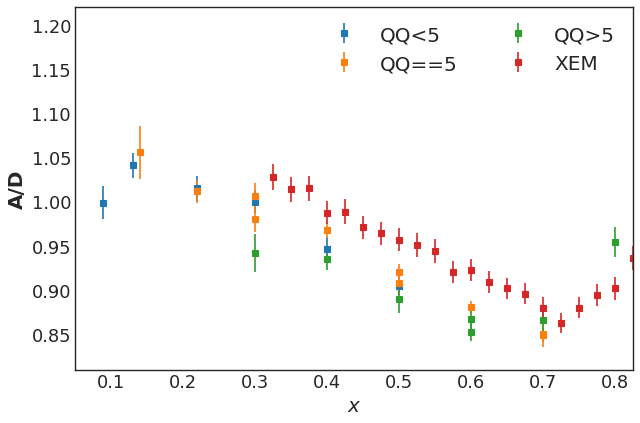

In [660]:
figb = plt.figure(figsize=(9,6),dpi=80)
ax = figb.add_subplot(111)


ax.errorbar(x=SLAC_data_F.query("qq<5")["x"],y=SLAC_data_F.query("qq<5")["Fe"],yerr=SLAC_data_F.query("qq<5")["Fe.err"]
            ,marker="s",fmt=" ",label="QQ<5")
ax.errorbar(x=SLAC_data_F.query("qq==5")["x"],y=SLAC_data_F.query("qq==5")["Fe"],yerr=SLAC_data_F.query("qq==5")["Fe.err"]
            ,marker="s",fmt=" ",label="QQ==5")
ax.errorbar(x=SLAC_data_F.query("qq>5")["x"],y=SLAC_data_F.query("qq>5")["Fe"],yerr=SLAC_data_F.query("qq>5")["Fe.err"]
            ,marker="s",fmt=" ",label="QQ>5")

DF=GetDFXem("Cu/D",40.0)

ax.errorbar(x=DF["x"],y=DF["Ratio"],yerr=DF["Comb err"]
            ,marker="s",fmt=" ",label="XEM")

ax.legend(ncol=2)
ax.set_xlim(0.05,0.825)
ax.set_ylim(0.81,1.22)
ax.set_ylabel("A/D")
ax.set_xlabel("$x$")

In [ ]:
#fig 18 
